<a href="https://colab.research.google.com/github/JasonDepblu/potential-spork/blob/main/Copy_of_content_based_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %%
import time
import pandas as pd
import numpy as np
import random
import mpl_toolkits.axisartist as ast
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow import keras
import tensorflow as tf
from keras import layers, models, optimizers
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, auc
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
import copy

In [2]:
# load the data
dsc_up_df = pd.read_csv(r'/content/dsc_up.csv')
car_dict_df = pd.read_csv(r'/content/car_dict2.csv')

dsc_up_df = dsc_up_df.replace({np.NaN: 0})
car_dict_df = car_dict_df.replace({np.NaN: 0})

dsc_up = dsc_up_df.values
car_dict = car_dict_df.values

print(dsc_up.shape)
print(car_dict.shape)

(47086, 35)
(191, 91)


In [7]:
# load the predict data of year 21-23
dsc_up_pre_df = pd.read_csv(r'/content/dsc_up_pre.csv')
car_dict_pre_df = pd.read_csv(r'/content/car_dict_pre.csv')

dsc_up_pre_df = dsc_up_pre_df.replace({np.NaN: 0})
car_dict_pre_df = car_dict_pre_df.replace({np.NaN: 0})

dsc_up_pre = dsc_up_pre_df.values
car_dict_pre = car_dict_pre_df.values

print(dsc_up_pre.shape)
print(car_dict_pre.shape)


(32342, 34)
(125, 92)


In [12]:
num_cars = len(car_dict)
num_cars_pre = len(car_dict_pre)
print(f'The No. of cars in fundamental model dataset : {num_cars}')
print(f'The No. of cars in prediction dataset : {num_cars_pre}')

The No. of cars in fundamental model dataset : 191
The No. of cars in prediction dataset : 125


In [13]:
# balance dsc_up samples
dsc_up_bal = np.empty(shape=(1, dsc_up.shape[1]))

for i in range(num_cars):
  if len(dsc_up[dsc_up[:, 32] == i]) > 1000:
    ran_row_bal = np.random.choice(np.arange(len(dsc_up[dsc_up[:, 32] == i])), size=1000, replace=False)
    dsc_up_bali = dsc_up[dsc_up[:, 32] == i][ran_row_bal]
  else:
    dsc_up_bali = dsc_up[dsc_up[:, 32] == i]
  dsc_up_bal = np.concatenate((dsc_up_bal, dsc_up_bali), axis=0)
dsc_up = dsc_up_bal[1:]
print(dsc_up.shape)

(44195, 35)


In [14]:
# load the label
print(f'The shape of cars dict of the fundamental model dataset : {car_dict.shape}')
print(f'The shape of users list of the fundamental model dataset : {dsc_up.shape}')

print(f'The shape of cars dict of the prediction dataset : {car_dict_pre.shape}')
print(f'The shape of users list of the prediction dataset : {dsc_up_pre.shape}')

ys_up = dsc_up[:, 32]
ys_up_pre = dsc_up_pre[:, 32]
print(f'The label of which user choosed which car in fundamental dataset : {ys_up}')
print(f'The label of which user choosed which car in prediction dataset : {ys_up_pre}')

The shape of cars dict of the fundamental model dataset : (191, 91)
The shape of users list of the fundamental model dataset : (44195, 35)
The shape of cars dict of the prediction dataset : (125, 92)
The shape of users list of the prediction dataset : (32342, 34)
The label of which user choosed which car in fundamental dataset : [0 0 0 ... 190 190 190]
The label of which user choosed which car in prediction dataset : [62 55 54 ... 9 9 75]


In [15]:
# transfer the label of fundamental dataset to onehot_code
ys = copy.copy(ys_up.reshape(len(ys_up), 1))
ys -= 1
onehot_encoder = OneHotEncoder(sparse_output=False)
onehot_encoded = onehot_encoder.fit_transform(ys)
ys = onehot_encoded
print(f'The shape of the label of fundamental dataset to onehot_code : {ys.shape}')

# transfer the label of prediction dataset to onehot_code
ys_pre = copy.copy(ys_up_pre.reshape(len(ys_up_pre), 1))
ys_pre -= 1
onehot_encoder_pre = OneHotEncoder(sparse_output=False)
onehot_encoded_pre = onehot_encoder_pre.fit_transform(ys_pre)
ys_pre = onehot_encoded_pre
print(f'The shape of the label of prediction dataset to onehot_code : {ys_pre.shape}')

(44195, 191)
(32342, 125)


In [17]:
# column of last feature from 0 and +1
col_last_feature_car = 90
# 80
col_last_feature_user = 29

car_unscaled = car_dict[:, 1:col_last_feature_car]
car_pre_unscaled = car_dict_pre[:, 1:col_last_feature_car]
user_unscaled = dsc_up[:, 1:col_last_feature_user]
user_pre_unscaled = dsc_up_pre[:, 1:col_last_feature_user]


# generate the gaussian random no. to budget feature
mu_budget = 0
sigma_budget = 1.5

for i in range(len(user_unscaled)):
    user_unscaled[i, 24] += random.gauss(mu_budget, sigma_budget)

for i in range(len(user_pre_unscaled)):
    user_pre_unscaled[i, 24] += random.gauss(mu_budget, sigma_budget)

# scaling the data
scalerCar = StandardScaler()
scalerCar.fit(car_dict[:, 1:col_last_feature_car])
car = scalerCar.transform(car_dict[:, 1:col_last_feature_car])
car_pre = scalerCar.transform(car_dict_pre[:, 1:col_last_feature_car])

scalerUser = StandardScaler()
scalerUser.fit(dsc_up[:, 1:col_last_feature_user])
user = scalerUser.transform(dsc_up[:, 1:col_last_feature_user])
user_pre = scalerUser.transform(dsc_up_pre[:, 1:col_last_feature_user])

print(np.allclose(car_unscaled.astype(float), scalerCar.inverse_transform(car)))
print(np.allclose(user_unscaled.astype(float), scalerUser.inverse_transform(user)))
print(np.allclose(car_pre_unscaled.astype(float), scalerCar.inverse_transform(car_pre)))
print(np.allclose(user_pre_unscaled.astype(float), scalerUser.inverse_transform(user_pre)))

True
True
True
True


In [18]:
# func for generating num_items users of different cars
def gen_user_vecs(user_vec, num_items):
    """ given a user vector return:
        user predict matrix to match the size of item_vecs """
    user_vecs = np.tile(user_vec, (1, num_items))
    return user_vecs

def gen_car_vecs(car_vec, num_users):
    car_vecs = np.tile(car_vec, (num_users, 1))
    return car_vecs

PCA(n_components=25)
[0.06458523 0.05523179 0.05407649 0.05018527 0.0453524  0.04270601
 0.03928786 0.03712248 0.03618061 0.03603403 0.03576069 0.03498561
 0.03466624 0.03430647 0.033671   0.03303069 0.03271151 0.03232417
 0.03207903 0.03170285 0.0307533  0.03000389 0.02930696 0.02887944
 0.0271969 ]
PCA(n_components=15)
[0.29650533 0.11418105 0.06267045 0.05660145 0.05051051 0.03779263
 0.03214934 0.02863958 0.02610614 0.02378182 0.02157888 0.02001022
 0.01758109 0.01621804 0.01479112]


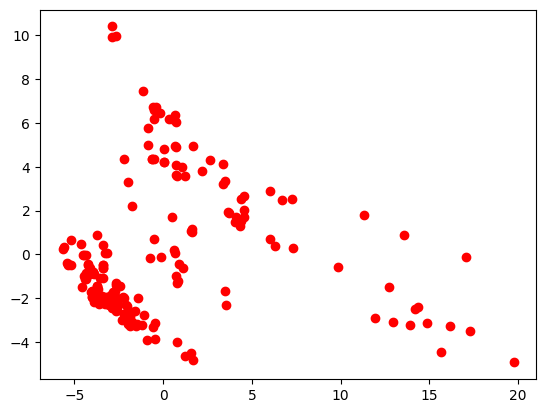

In [29]:
# pca analysis
pca_25 = PCA(n_components=25)
print(pca_25)
pca_25.fit(user)
print(pca_25.explained_variance_ratio_)

# %%
pca_30 = PCA(n_components=15)
print(pca_30)
pca_30.fit(car[:, 1:90])
print(pca_30.explained_variance_ratio_)
c_trans = pca_30.transform(car[:, 1:90])
plt.plot(c_trans[:, 0], c_trans[:, 1], 'ro')


In [30]:
# generate num_items users for different cars
user_vecs = gen_user_vecs(user, len(car_dict))
user_vecs = user_vecs.reshape(-1, user.shape[1])
car_vecs = gen_car_vecs(car, len(dsc_up))
ys = ys.reshape(-1, 1)
print(f'The shape of user matrix in fundamental dataset : {user_vecs.shape}')
print(f'The shape of car matrix in fundamental dataset : {car_vecs.shape}')
print(f'The shape of label matrix in fundamental dataset : {ys.shape}')

user_pre_vecs = gen_user_vecs(user_pre, len(car_dict_pre))
user_pre_vecs = user_pre_vecs.reshape(-1, user_pre.shape[1])
car_pre_vecs = gen_car_vecs(car_pre, len(dsc_up_pre))
ys_pre = ys_pre.reshape(-1, 1)
print(f'The shape of user matrix in prediction dataset : {user_pre_vecs.shape}')
print(f'The shape of car matrix in prediction dataset : {car_pre_vecs.shape}')
print(f'The shape of label matrix in fundamental dataset : {ys_pre.shape}')

The shape of user matrix in fundamental dataset : (8441245, 28)
The shape of car matrix in fundamental dataset : (8441245, 89)
The shape of label matrix in fundamental dataset : (8441245, 1)
The shape of user matrix in prediction dataset : (4042750, 28)
The shape of car matrix in prediction dataset : (4042750, 89)
The shape of label matrix in fundamental dataset : (4042750, 1)


In [32]:
print(ys[ys == 0].shape)
print(ys_pre[ys_pre == 0].shape)

(8397050,)
(4010408,)


In [ ]:
# # case 2
# car_train, car_test = train_test_split(car_vecs, train_size=0.8, shuffle=True, random_state=2023)
# user_train, user_test = train_test_split(user_vecs, train_size=0.8, shuffle=True, random_state=2023)
# ys_train, ys_test = train_test_split(ys, train_size=0.8, shuffle=True, random_state=2023)

# car_val, car_test = train_test_split(car_test, train_size=0.5, shuffle=True, random_state=2023)
# user_val, user_test = train_test_split(user_test, train_size=0.5, shuffle=True, random_state=2023)
# ys_val, ys_test = train_test_split(ys_test, train_size=0.5, shuffle=True, random_state=2023)

In [33]:
randnum = random.randint(0, 100)
print(randnum)
random.seed(randnum)

48


In [ ]:
# # case 2
# user_train_one = user_train[(ys_train == 1)[:, 0]]
# user_train_one = gen_car_vecs(user_train_one, np.ceil(len(car_dict) * 0.3 -1).astype(int))
# user_train_zero = user_train[(ys_train == 0)[:, 0]]
# user_train = np.concatenate((user_train_zero, user_train_one), axis=0)
# random.seed(randnum)
# random.shuffle(user_train)
# print(user_train.shape)

In [ ]:
# # case 2
# car_train_one = car_train[(ys_train == 1)[:, 0]]
# car_train_one = gen_car_vecs(car_train_one, np.ceil(len(car_dict) * 0.3 -1).astype(int))
# car_train_zero = car_train[(ys_train == 0)[:, 0]]
# car_train = np.concatenate((car_train_zero, car_train_one), axis=0)
# random.seed(randnum)
# random.shuffle(car_train)
# print(car_train.shape)

In [ ]:
# # case 2
# ys_one = ys_train[(ys_train == 1)[:, 0]]
# ys_one = gen_car_vecs(ys_one, np.ceil(len(car_dict) * 0.3 -1).astype(int))
# ys_zero = ys_train[(ys_train == 0)[:, 0]]
# ys_train = np.concatenate((ys_zero, ys_one), axis=0)
# random.seed(randnum)
# random.shuffle(ys_train)
# print(ys_train.shape)

In [ ]:
# user_vecs_one = user_vecs[(ys == 1)[:, 0]]

In [ ]:
# num_users = user_vecs_one.shape[0]
# print(num_users)


In [ ]:
# user_vecs_zero = user_vecs[(ys == 0)[:, 0]]
# num_zeros = user_vecs_zero.shape[0]
# print(num_zeros)

In [ ]:
# random.seed(randnum)

In [ ]:
# sample_row = np.random.choice(np.arange(num_zeros), size=num_users, replace=False)

In [ ]:
# sample_row

In [ ]:
# user_vecs_zero = user_vecs_zero[sample_row]
# print(user_vecs_zero.shape)

In [34]:
# case 3
# Random choose the users which label is 0 in fundamental dataset

user_vecs_one = user_vecs[(ys == 1)[:, 0]]
user_vecs_zero = user_vecs[(ys == 0)[:, 0]]
num_users = user_vecs_one.shape[0]
num_zeros = user_vecs_zero.shape[0]
random.seed(randnum)

sample_row = np.random.choice(np.arange(num_zeros), size=np.ceil(num_users * 1.2).astype(int), replace=False)
user_vecs_zero = user_vecs_zero[sample_row]
user_vecs = np.concatenate((user_vecs_zero, user_vecs_one), axis=0)

random.seed(44)
shuffle_row = np.random.choice(np.arange(0,len(user_vecs)), len(user_vecs), replace=False)
user_vecs = user_vecs[shuffle_row]
print(f'The shape of the users data in fundatmental dataset after balancing : {user_vecs.shape}')

The shape of the users data in fundatmental dataset after balancing : (97229, 28)


In [35]:
# case3
# Random choose the cars which label is 0 in fundamental dataset

car_vecs_one = car_vecs[(ys == 1)[:, 0]]
car_vecs_zero = car_vecs[(ys == 0)[:, 0]][sample_row]
car_vecs = np.concatenate((car_vecs_zero, car_vecs_one), axis=0)

car_vecs = car_vecs[shuffle_row]
print(f'The shape of the cars data in fundatmental dataset after balancing : {car_vecs.shape}')

The shape of the cars data in fundatmental dataset after balancing : (97229, 89)


In [36]:
# case 3
# Random choose the label which is 0 in fundamental dataset
ys_one = ys[(ys == 1)[:, 0]]
ys_zero = ys[(ys == 0)[:, 0]][sample_row]
ys = np.concatenate((ys_zero, ys_one), axis=0)

ys = ys[shuffle_row]
print(f'The shape of label data in fundatmental dataset after balancing : {ys.shape}')

The shape of label data in fundatmental dataset after balancing : (97229, 1)


In [37]:
# Random choose the users which label is 0 in prediction dataset

user_pre_vecs_one = user_pre_vecs[(ys_pre == 1)[:, 0]]
user_pre_vecs_zero = user_pre_vecs[(ys_pre == 0)[:, 0]]
num_users_pre = user_pre_vecs_one.shape[0]
num_zeros_pre = user_pre_vecs_zero.shape[0]
random.seed(randnum)

sample_row_pre = np.random.choice(np.arange(num_zeros_pre), size=np.ceil(num_users_pre * 1.2).astype(int), replace=False)
user_pre_vecs_zero = user_pre_vecs_zero[sample_row_pre]
user_pre_vecs = np.concatenate((user_pre_vecs_zero, user_pre_vecs_one), axis=0)

random.seed(54)
shuffle_row_pre = np.random.choice(np.arange(0,len(user_pre_vecs)), len(user_pre_vecs), replace=False)
user_pre_vecs = user_vecs[shuffle_row_pre]
print(f'The shape of the users data in fundatmental dataset after balancing : {user_pre_vecs.shape}')

The shape of the users data in fundatmental dataset after balancing : (71153, 28)


In [38]:
# Random choose the cars which label is 0 in prediction dataset

car_pre_vecs_one = car_pre_vecs[(ys_pre == 1)[:, 0]]
car_pre_vecs_zero = car_pre_vecs[(ys_pre == 0)[:, 0]][sample_row_pre]
car_pre_vecs = np.concatenate((car_pre_vecs_zero, car_pre_vecs_one), axis=0)

car_pre_vecs = car_pre_vecs[shuffle_row_pre]
print(f'The shape of the cars data in prediction dataset after balancing : {car_pre_vecs.shape}')

The shape of the cars data in prediction dataset after balancing : (71153, 89)


In [40]:
# Random choose the label which is 0 in prediction dataset
ys_pre_one = ys_pre[(ys_pre == 1)[:, 0]]
ys_pre_zero = ys_pre[(ys_pre == 0)[:, 0]][sample_row_pre]
ys_pre = np.concatenate((ys_pre_zero, ys_pre_one), axis=0)

ys_pre = ys_pre[shuffle_row_pre]
print(f'The shape of label data in prediction dataset after balancing : {ys_pre.shape}')

The shape of label data in prediction dataset after balancing : (71153, 1)


In [41]:
# case 3
car_train, car_test = train_test_split(car_vecs, train_size=0.8, shuffle=True, random_state=2023)
user_train, user_test = train_test_split(user_vecs, train_size=0.8, shuffle=True, random_state=2023)
ys_train, ys_test = train_test_split(ys, train_size=0.8, shuffle=True, random_state=2023)

car_val, car_test = train_test_split(car_test, train_size=0.5, shuffle=True, random_state=2023)
user_val, user_test = train_test_split(user_test, train_size=0.5, shuffle=True, random_state=2023)
ys_val, ys_test = train_test_split(ys_test, train_size=0.5, shuffle=True, random_state=2023)

In [42]:
print(f"cars training data shape:{car_train.shape}")
print(f"cars validating data shape:{car_val.shape}")
print(f"cars testing data shape:{car_test.shape}")

print(f"users training data shape:{user_train.shape}")
print(f"users validating data shape:{user_val.shape}")
print(f"users testing data shape:{user_test.shape}")

print(f"ys training data shape:{ys_train.shape}")
print(f"ys validating data shape:{ys_val.shape}")
print(f"ys testing data shape:{ys_test.shape}")

cars training data shape:(77783, 89)
cars validating data shape:(9723, 89)
cars testing data shape:(9723, 89)
users training data shape:(77783, 28)
users validating data shape:(9723, 28)
users testing data shape:(9723, 28)
ys training data shape:(77783, 1)
ys validating data shape:(9723, 1)
ys testing data shape:(9723, 1)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 89)]         0           []                               
                                                                                                  
 sequential (Sequential)        (None, 32)           44448       ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 32)           60064       ['input_2[0][0]']                
                                                                                              

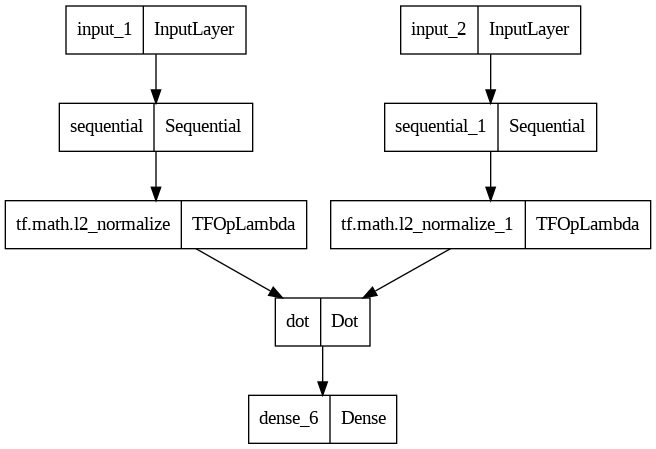

In [43]:
num_user_features = col_last_feature_user-1
num_car_features = col_last_feature_car-1
num_outputs = 32
tf.random.set_seed(1)
user_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs, activation='relu'),
])
car_NN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_outputs, activation='relu'),
])

input_user = tf.keras.layers.Input(shape=(num_user_features))
vu = user_NN(input_user)
vu = tf.linalg.l2_normalize(vu, axis=1)

input_car = tf.keras.layers.Input(shape=(num_car_features))
vc = car_NN(input_car)
vc = tf.linalg.l2_normalize(vc, axis=1)

d_out = tf.keras.layers.Dot(axes=1)([vu, vc])
output = tf.keras.layers.Dense(1, activation='sigmoid')(d_out)

model = tf.keras.Model([input_user, input_car], output)
model.summary()
tf.keras.utils.plot_model(model, "/content/my_model.png")

In [44]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss=cost_fn)

In [45]:
tf.random.set_seed(1)
model.fit([user_train, car_train], ys_train, epochs=5)

Epoch 1/5
2431/2431 [==============================] - 10s 3ms/step - loss: 0.1571
Epoch 2/5
2431/2431 [==============================] - 9s 4ms/step - loss: 0.1218
Epoch 3/5
2431/2431 [==============================] - 8s 3ms/step - loss: 0.1162
Epoch 4/5
2431/2431 [==============================] - 7s 3ms/step - loss: 0.1128
Epoch 5/5
2431/2431 [==============================] - 8s 3ms/step - loss: 0.1106


In [46]:
model.evaluate([user_val, car_val], ys_val)

304/304 [==============================] - 1s 2ms/step - loss: 0.1114


0.11136681586503983

In [47]:
model.evaluate([user_val[(ys_val == 0)[:, 0]], car_val[(ys_val == 0)[:, 0]]], ys_val[(ys_val == 0)[:, 0]])
model.evaluate([user_val[(ys_val == 1)[:, 0]], car_val[(ys_val == 1)[:, 0]]], ys_val[(ys_val == 1)[:, 0]])

138/138 [==============================] - 0s 3ms/step - loss: 0.1029


0.10293770581483841

In [48]:
ys_test.shape

(9723, 1)

In [49]:
model.evaluate([user_test[(ys_test == 0)[:, 0]], car_test[(ys_test == 0)[:, 0]]], ys_test[(ys_test == 0)[:, 0]])
model.evaluate([user_test[(ys_test == 1)[:, 0]], car_test[(ys_test == 1)[:, 0]]], ys_test[(ys_test == 1)[:, 0]])

138/138 [==============================] - 0s 2ms/step - loss: 0.1068


0.10682691633701324

In [50]:
ys_p_test = model.predict([[user_test, car_test]])
ys_p_test_vs = np.concatenate((ys_p_test, ys_test), axis=1)
ys_test_df = pd.DataFrame(ys_p_test_vs)
ys_test_df.to_csv(r'/content/ys_p_test_6epoch.csv', encoding='UTF-8')

304/304 [==============================] - 1s 2ms/step


In [51]:
# print the confusion matrix & report
print(confusion_matrix(ys_test, np.round(ys_p_test)))
print(classification_report(ys_test, np.round(ys_p_test)))

[[4380  931]
 [ 615 3797]]
              precision    recall  f1-score   support

         0.0       0.88      0.82      0.85      5311
         1.0       0.80      0.86      0.83      4412

    accuracy                           0.84      9723
   macro avg       0.84      0.84      0.84      9723
weighted avg       0.84      0.84      0.84      9723



AUC: 0.9190913144395055


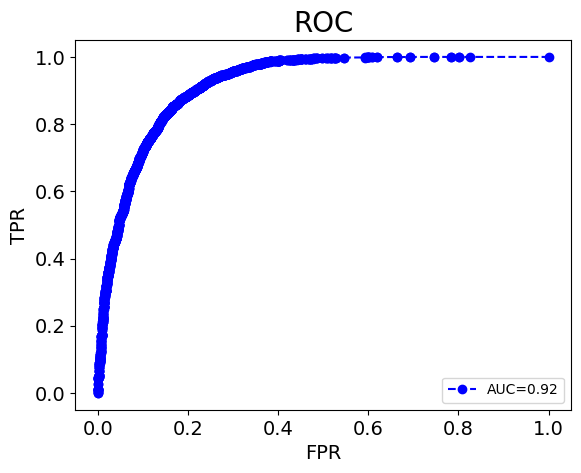

In [52]:
# calculate the auc & roc
FPR, TPR, thresholds = metrics.roc_curve(ys_test, ys_p_test)
AUC = auc(FPR, TPR)
print('AUC:',AUC)
plt.rc('font', family='', size=14)
plt.plot(FPR,TPR,label="AUC={:.2f}" .format(AUC),marker = 'o',color='b',linestyle='--')
plt.legend(loc=4, fontsize=10)
plt.title('ROC',fontsize=20)
plt.xlabel('FPR',fontsize=14)
plt.ylabel('TPR',fontsize=14)
plt.show()

In [53]:
ys_p_train = model.predict([[user_train, car_train]])

2431/2431 [==============================] - 5s 2ms/step


In [54]:
# print the confusion matrix & report
print(confusion_matrix(ys_train, np.round(ys_p_train)))
print(classification_report(ys_train, np.round(ys_p_train)))

[[35313  7089]
 [ 4383 30998]]
              precision    recall  f1-score   support

         0.0       0.89      0.83      0.86     42402
         1.0       0.81      0.88      0.84     35381

    accuracy                           0.85     77783
   macro avg       0.85      0.85      0.85     77783
weighted avg       0.86      0.85      0.85     77783



In [55]:
# predict the users of year 21-23 whether buy the cars in scope
ys_p_pre = model.predict([user_pre_vecs, car_pre_vecs])

2224/2224 [==============================] - 4s 2ms/step


In [56]:
# print the confusion matrix & report
print(confusion_matrix(ys_pre, np.round(ys_p_pre)))
print(classification_report(ys_pre, np.round(ys_p_pre)))

[[28236 10575]
 [22743  9599]]
              precision    recall  f1-score   support

         0.0       0.55      0.73      0.63     38811
         1.0       0.48      0.30      0.37     32342

    accuracy                           0.53     71153
   macro avg       0.51      0.51      0.50     71153
weighted avg       0.52      0.53      0.51     71153



AUC: 0.5006169111328074


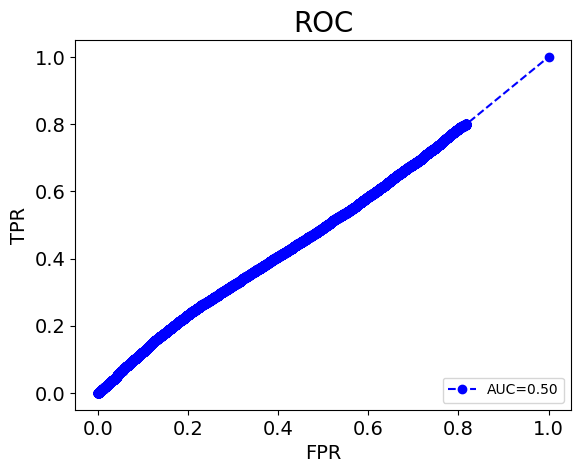

In [57]:
# calculate the auc & roc
FPR, TPR, thresholds = metrics.roc_curve(ys_pre, ys_p_pre)
AUC = auc(FPR, TPR)
print('AUC:',AUC)
plt.rc('font', family='', size=14)
plt.plot(FPR,TPR,label="AUC={:.2f}" .format(AUC),marker = 'o',color='b',linestyle='--')
plt.legend(loc=4, fontsize=10)
plt.title('ROC',fontsize=20)
plt.xlabel('FPR',fontsize=14)
plt.ylabel('TPR',fontsize=14)
plt.show()

基于某个用户，预测不同的车的购买倾向

In [ ]:
list = []
for i in range(len(dsc_up)):
  if dsc_up[i, 32] == 7:
    list.append(i)
print(list)

[2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044, 2045, 2046, 2047, 2048, 2049, 2050, 2051, 2052, 2053, 2054, 2055, 2056, 2057, 2058, 2059, 2060, 2061, 2062, 2063, 2064, 2065, 2066, 2067, 2068, 2069, 2070, 2071, 2072, 2073, 2074, 2075, 2076, 2077, 2078, 2079, 2080, 2081, 2082, 2083, 2084, 2085, 2086, 2087, 2088, 2089, 2090, 2091, 2092, 2093, 2094, 2095, 2096, 2097, 2098, 2099, 2100, 2101, 2102, 2103, 2104, 2105, 2106, 2107, 2108, 2109, 2110, 2111, 2112, 2113, 2114, 2115, 2116, 2117, 2118, 2119, 2120, 2121, 2122, 2123, 2124, 2125, 2126, 2127, 2128, 2129, 2130, 2131, 2132, 2133, 2134, 2135, 2136, 2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146, 2147, 2148, 2149, 2150, 2151, 2152, 2153, 2154, 2155, 2156, 2157, 2158, 2159, 2160, 2161, 2162, 2163, 2164, 2165, 2166, 2167, 2168, 2169, 2170, 2171, 2172, 2173, 2174, 2175, 2176, 2177, 2178, 2179, 2180, 2181, 2182, 2183, 2184, 2185, 2186, 2187, 2188, 2189, 2190, 2191, 2192, 2193, 2194, 2195, 2196, 2197, 2198, 2199, 2200, 220

In [ ]:
dsc_up[2047, :]

array([3358153, 3, 3, 3, 2, 3, 3, 4, 3, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2300, 3, 7.911861159554745, 5,
       3, 24, '宋Pro', 5178, 40569, 7, '2019款 1.5T 自动豪华型', 40569],
      dtype=object)

In [ ]:
# predict the new car of new performance for specific user
# define the cars and the user
row_car_dict = np.arange(0, num_cars) 
row_user_dst = [2047]
new_car = car_unscaled[row_car_dict]
new_user = gen_car_vecs(user_unscaled[row_user_dst], len(row_car_dict))

# predict the new car of new performance
new_user_scal = scalerUser.transform(new_user)
new_car_scal = scalerCar.transform(new_car)
new_car_predict = model.predict([[new_user_scal, new_car_scal]])
print(f'target car is {dsc_up[row_user_dst, 33]}, car No. is {dsc_up[row_user_dst, 32]}')
for i in range(len(row_car_dict)):
    print(
        f'{i} :'
        f'{car_dict[row_car_dict, 91].reshape(-1, 1)[i]} : {np.round(new_car_predict[i],3)} : {np.round(new_car_predict[i], 0)}')

In [ ]:
new_y_predict = np.zeros((new_car_predict.shape))
new_y_predict [new_car_predict > 0.8] = 1
new_y_true = np.zeros((new_y_predict.shape))
new_y_true[row_car_dict == dsc_up[row_user_dst, 32]] = 1

print(confusion_matrix(new_y_true, new_y_predict))
print(classification_report(new_y_true, new_y_predict))


[[186   4]
 [  0   1]]
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99       190
         1.0       0.20      1.00      0.33         1

    accuracy                           0.98       191
   macro avg       0.60      0.99      0.66       191
weighted avg       1.00      0.98      0.99       191



In [ ]:
dsc_up[row_user_dst, 32]

array([7], dtype=object)

In [ ]:
new_y_predict_vs = np.concatenate((new_y_predict, new_y_true), axis=1)
new_y_predict_vs = np.concatenate((new_car_predict, new_y_predict_vs), axis=1)
new_y_predict_df = pd.DataFrame(new_y_predict_vs)
new_y_predict_df.to_csv(r'/content/new_car_predict_vs.csv', encoding='UTF-8')

基于某款车预测不同用户的购买倾向

In [ ]:
row_car_dict = [7]
row_user_dst = np.arange(0, num_users)
new_car = gen_car_vecs(car_unscaled[row_car_dict], len(row_user_dst))
new_user = user_unscaled[row_user_dst]

new_user_scal = scalerUser.transform(new_user)
new_car_scal = scalerCar.transform(new_car)
new_car_predict = model.predict([[new_user_scal, new_car_scal]])

print(f'target car is {car_dict[row_car_dict, 91]}, car No. is {car_dict[row_car_dict, 92]}')
for i in range(min(len(row_user_dst), 200)):
    print(
        f'User{i} who has bought car:'
        f'{dsc_up[row_user_dst, 29].reshape(-1, 1)[i]} : {np.round(new_car_predict[i],3)} : {np.round(new_car_predict[i], 0)}')

In [ ]:
new_y_predict = np.zeros((new_car_predict.shape))
new_y_predict [new_car_predict > 0.86] = 1
new_y_true = np.zeros((new_y_predict.shape))
new_y_true[dsc_up[row_user_dst, 32] == row_car_dict] = 1

print(confusion_matrix(new_y_true, new_y_predict))
print(classification_report(new_y_true, new_y_predict))

[[29750 13445]
 [  212   788]]
              precision    recall  f1-score   support

         0.0       0.99      0.69      0.81     43195
         1.0       0.06      0.79      0.10      1000

    accuracy                           0.69     44195
   macro avg       0.52      0.74      0.46     44195
weighted avg       0.97      0.69      0.80     44195



In [ ]:
new_y_predict_vs = np.concatenate((new_y_predict, new_y_true), axis=1)
new_y_predict_vs = np.concatenate((new_car_predict, new_y_predict_vs), axis=1)
new_y_predict_vs = np.concatenate((dsc_up[row_user_dst, 32].reshape(-1, 1), new_y_predict_vs), axis=1)
new_y_predict_df = pd.DataFrame(new_y_predict_vs)
new_y_predict_df.to_csv(r'/content/new_user_predict_vs3.csv', encoding='UTF-8')

In [ ]:
new_y_predict [new_car_predict > 0.86].shape

(14233,)

修改某款车性能参数，预测不同用户的购买倾向

In [ ]:
# 32 宋DMIDMI110km
# 56 低配影酷
car_unscaled[56, 0]

11.98

In [ ]:
# base car parameters
row_car_dict = [56]
row_user_dst = np.arange(0, num_users)
new_car_one = car_unscaled[row_car_dict]
print(new_car_one)

[[11.98 7 1 2 1 0.0 0.0 130 270 1 190 8.35 0 735 3.0 350.0 165.0 350.0
  0.0 0.0 1.0 0 0 0 1 1 0 0 4680 1901 1670 2750 1617 1610 1915 1500 5 1 2
  2 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 4 1 1 3 1 4 1 1 1 1 0.0 1 3 1 1 1 1 1
  7.0 0 39.1 58.1 59.5 66.7]]


In [ ]:
# modify the paramters of some car
new_car_one[:, 0:14] = car_unscaled[32, 0:14]
print(new_car_one)

[[17.58 4 1 3 3 0.7 5.5 81 135 1 170 7.9 110 1443 3.0 350.0 165.0 350.0
  0.0 0.0 1.0 0 0 0 1 1 0 0 4680 1901 1670 2750 1617 1610 1915 1500 5 1 2
  2 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 4 1 1 3 1 4 1 1 1 1 0.0 1 3 1 1 1 1 1
  7.0 0 39.1 58.1 59.5 66.7]]


In [ ]:
new_car = gen_car_vecs(new_car_one, len(row_user_dst))
new_user = user_unscaled[row_user_dst]

new_user_scal = scalerUser.transform(new_user)
new_car_scal = scalerCar.transform(new_car)
new_car_predict = model.predict([[new_user_scal, new_car_scal]])

print(f'target car is {car_dict[row_car_dict, 81]}, car No. is {car_dict[row_car_dict, 82]}')
for i in range(min(len(row_user_dst), 100)):
    print(
        f'User{i} who has bought car:'
        f'{dsc_up[row_user_dst, 32].reshape(-1, 1)[i]} : {np.round(new_car_predict[i],3)} : {np.round(new_car_predict[i], 0)}')

In [ ]:
new_y_predict_modify = np.concatenate((dsc_up[row_user_dst, 32].reshape(-1, 1), new_car_predict), axis=1)
new_y_predict = np.zeros((new_car_predict.shape))
new_y_predict [new_car_predict > 0.8] = 1
new_y_predict_modify = np.concatenate((new_y_predict_modify, new_y_predict), axis=1)
new_y_predict_modify_df = pd.DataFrame(new_y_predict_modify)
new_y_predict_modify_df.to_csv(r'/content/new_user_predict_modify.csv', encoding='UTF-8')

In [ ]:
new_y_predict [new_car_predict > 0.8].shape

(3196,)

In [ ]:
dsc_up.shape

(9492, 33)

**修改某款车参数为未来热销车型参数，预测原有用户是否购买**

---



---



In [ ]:
car_unscaled[56, 0]

In [65]:
# new car parameters
row_car_dict = [61]
row_user_dst = np.arange(0, num_users)
new_car_one = car_pre_unscaled[row_car_dict]
print(new_car_one)

[[20.08 4 1 1 3 100000 0.0 0.0 126 209 1 180 10.34 0 932 1 10 9 0 0 0 0 0
  0 0 0 0 0 0 1 1 4 0 0 0 4600 1855 1680 2690 1607 1621 1565 5 0 0 2 2 0
  2 0 3.0 0 4.0 0 0 0 0 8 10 10 0 12 0 6 3 2 3 0 2 0 0 0 0 0 10.1 0 0 0 2
  0 3 1 0 0 0 40.1 57.5 61.1 66.3]]


In [66]:
new_car = gen_car_vecs(new_car_one, len(row_user_dst))
new_user = user_unscaled[row_user_dst]

new_user_scal = scalerUser.transform(new_user)
new_car_scal = scalerCar.transform(new_car)
new_car_predict = model.predict([[new_user_scal, new_car_scal]])

print(f'target car is {car_dict_pre[row_car_dict, 91]}, car No. is {car_dict_pre[row_car_dict, 91]}')
for i in range(min(len(row_user_dst), 10000)):
    print(
        f'User{i} who has bought car:'
        f'{dsc_up[row_user_dst, 29].reshape(-1, 1)[i]} : {np.round(new_car_predict[i],3)} : {np.round(new_car_predict[i], 0)}')

Streaming output truncated to the last 5000 lines.
User5000 who has bought car:['长安CS35 PLUS'] : [0.005] : [0.]
User5001 who has bought car:['长安CS35 PLUS'] : [0.005] : [0.]
User5002 who has bought car:['长安CS35 PLUS'] : [0.005] : [0.]
User5003 who has bought car:['长安CS35 PLUS'] : [0.006] : [0.]
User5004 who has bought car:['长安CS35 PLUS'] : [0.005] : [0.]
User5005 who has bought car:['长安CS35 PLUS'] : [0.005] : [0.]
User5006 who has bought car:['长安CS35 PLUS'] : [0.005] : [0.]
User5007 who has bought car:['长安CS35 PLUS'] : [0.005] : [0.]
User5008 who has bought car:['长安CS35 PLUS'] : [0.007] : [0.]
User5009 who has bought car:['长安CS35 PLUS'] : [0.006] : [0.]
User5010 who has bought car:['长安CS35 PLUS'] : [0.006] : [0.]
User5011 who has bought car:['长安CS35 PLUS'] : [0.005] : [0.]
User5012 who has bought car:['长安CS35 PLUS'] : [0.005] : [0.]
User5013 who has bought car:['长安CS35 PLUS'] : [0.005] : [0.]
User5014 who has bought car:['长安CS35 PLUS'] : [0.005] : [0.]
User5015 who has bought car:['长安CS

In [67]:
new_y_predict_modify = np.concatenate((dsc_up[row_user_dst, 29].reshape(-1, 1), new_car_predict), axis=1)
new_y_predict = np.zeros((new_car_predict.shape))
new_y_predict [new_car_predict > 0.8] = 1
new_y_predict_modify = np.concatenate((new_y_predict_modify, new_y_predict), axis=1)
new_y_predict_modify_df = pd.DataFrame(new_y_predict_modify)
new_y_predict_modify_df.to_csv(r'/content/new_user_predict_modify_RAV4.csv', encoding='UTF-8')

In [63]:
new_y_predict [new_car_predict > 0.8].shape

(6663,)

In [64]:
dsc_up.shape

(44195, 35)

修改用户地点，预测用户购买某款车的倾向变化

In [ ]:
row_car_dict = [11]
row_user_dst = np.arange(0, num_users)
new_car_one = car_unscaled[row_car_dict]
new_car = gen_car_vecs(new_car_one, len(row_user_dst))
new_user = user_unscaled[row_user_dst]

In [ ]:
# modify the place of users
# 吉林：26 长春：295
# 广东：1 广州：115
# 广东：1 深圳：195
new_user[:, (22,24)] = [(115, 1)]
print(new_user[0:10,(22,24)])

[[115 1]
 [115 1]
 [115 1]
 [115 1]
 [115 1]
 [115 1]
 [115 1]
 [115 1]
 [115 1]
 [115 1]]


In [ ]:
new_user[0]

array([3, 3, 2, 3, 2, 3, 3, 3, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 100, 115, 12.383482437349597, 1, 0, 7],
      dtype=object)

In [ ]:
new_user_scal = scalerUser.transform(new_user)
new_car_scal = scalerCar.transform(new_car)
new_car_predict = model.predict([[new_user_scal, new_car_scal]])

print(f'target car is {car_dict[row_car_dict, 81]}, car No. is {car_dict[row_car_dict, 82]}')
for i in range(min(len(row_user_dst), 100)):
    print(
        f'User{i} who has bought car:'
        f'{dsc_up[row_user_dst, 32].reshape(-1, 1)[i]} : {np.round(new_car_predict[i],3)} : {np.round(new_car_predict[i], 0)}')

In [ ]:
threshold_p = 0.23
new_y_predict [new_car_predict > threshold_p].shape

(460,)

In [ ]:
num_users

9492

In [ ]:
new_y_predict_modify = np.concatenate((dsc_up[row_user_dst, 32].reshape(-1, 1), new_car_predict), axis=1)
new_y_predict = np.zeros((new_car_predict.shape))
new_y_predict [new_car_predict > threshold_p] = 1
new_y_predict_modify = np.concatenate((new_y_predict_modify, new_y_predict), axis=1)
new_y_predict_modify_df = pd.DataFrame(new_y_predict_modify)
new_y_predict_modify_df.to_csv(r'/content/new_user_predict_modify_place.csv', encoding='UTF-8')

**others：**

In [ ]:
new_car_predict = np.concatenate((new_car_predict, dsc_up[0:, 30].reshape(-1, 1)), axis=1)
new_car_predict_df = pd.DataFrame(new_car_predict)
new_car_predict_df.to_csv(r'/content/new_car_predict3.csv', encoding='UTF-8')

In [ ]:
a = np.array([0,1,2])
b = np.array([1,2,3])
print(np.dot(a,b))

8
